In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
from src.utils import pathsetup, split_by_trials
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.worldModels import *
from src.utils import *
from src.run_simulations import *
from src.agents import *
from tqdm.notebook import tqdm

import pickle

%matplotlib inline

%reload_ext autoreload
%autoreload 2


## Simulating a single agent (Fig. 1 schematic)

Skipping save...


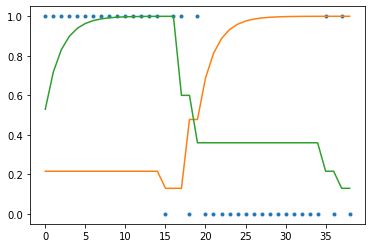

In [4]:
params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=5,
             eps=0, hmm_fit=False, sigmoid_window=30,
             ntrials_per_block=[15, 25], gammalst=[0.4], epslst=[0.1],
             rlow=0, rhigh=1, type='qlearning')

np.random.seed(123)
agent, world, _, _, _ = run_single_agent(0, 0, params)

plt.plot(agent.choice_history[37:76], '.')
plt.plot(agent.q0_history[37:76])
plt.plot(agent.q1_history[37:76])

paths = pathsetup('matchingsim')
filepath = f"{paths['simdatapath']}/schematic/qlearning-sim-122221.mat"
if not os.path.exists(filepath):
    scipy.io.savemat(f"{paths['simdatapath']}/schematic/qlearning-sim-122221.mat", 
                dict(choices=agent.choice_history[37:76], q0=agent.q0_history[37:76], 
                     q1=agent.q1_history[37:76], rewards=agent.outcome_history[37:76],
                    params=params))
    print('File saved')
else:
    print('Skipping save...')

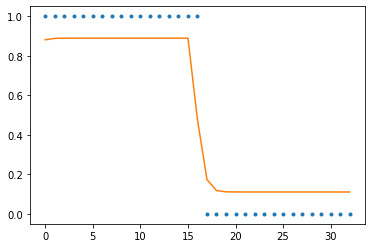

In [5]:
# Inference-based agent
params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=5,
             eps=0, hmm_fit=False, sigmoid_window=30,
             ntrials_per_block=[15, 25], pswitchlst=[0.1], prewlst=[0.9],
             rlow=0, rhigh=1, type='inf-based')

np.random.seed(123)
agent, world, _, _, _ = run_single_agent(0, 0, params)

plt.plot(agent.choice_history[1:34], '.')
plt.plot(agent.p1_history[1:34])

paths = pathsetup('matchingsim')
# scipy.io.savemat(f"{paths['simdatapath']}/schematic/infbased-sim-122221.mat", 
#                 dict(choices=agent.choice_history[1:34], prob0=agent.p0_history[1:34], 
#                      prob1=agent.p1_history[1:34], rewards=agent.outcome_history[1:34],
#                     params=params))

## Simulation of example q-learning and inf-based agents

In [6]:
# Simulating the behavior of agents along the eps-gamma axis
epslst = [0.1, 0.1, 0.1, 0.5, 0.2, 0.01]
gammalst = [0.1, 0.5, 1.2, 1.2, 1.2, 1.2]

pswitchlst = [0.45, 0.2, 0.01, 0.45, 0.2, 0.01]
prewlst = [0.99, 0.7, 0.55, 0.99, 0.7, 0.55]
simtype = 'qlearning'
Tmax = 6
Niter = 10

choicelst_all = []
params_all = []
pfits = []
coefs_all = []
perf_train_all = []
perf_test_all = []


for i in tqdm(range(len(epslst))):
    if simtype == 'qlearning':
        params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=1000,
                 eps=0, hmm_fit=False, sigmoid_window=30,
                 ntrials_per_block=[15, 25], gammalst=[gammalst[i]], epslst=[epslst[i]],
                 rlow=0, rhigh=1, type=simtype)
    elif simtype == 'inf-based':
        params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=1000,
                 eps=0, hmm_fit=False, sigmoid_window=30,
                 ntrials_per_block=[15, 25], pswitchlst=[pswitchlst[i]], prewlst=[prewlst[i]],
                 rlow=0, rhigh=1, type=simtype)

    np.random.seed(123)
    
    # Repeated simulation to find error bars for history regression
    for j in range(Niter):
        agent, world, _, _, _ = run_single_agent(0, 0, params)

        coefs, perf_train, perf_test = agent.do_history_logistic_fit(Tmax=Tmax)
        perf_train_all.append(perf_train)
        perf_test_all.append(perf_test)
        coefs_all.append(coefs)

    choicelst = split_by_trials(agent.outcome_history, world.ntrialblocks[:-1], chop='max')
#     choicelst[1::2] = 1 - choicelst[1::2]

    # Fit a simgoidal curve
    average = np.nanmean(choicelst, axis=0)
    pfit = fit_doublesigmoid_helper(average, 1 - average)
    pfits.append(pfit)
    
    
    params_all.append(params)
    choicelst_all.append(choicelst)
    
# extract only the offset, slope, lapse    
pfits = np.array(pfits)[:, [0, 1, 4]]
    

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
version = '122821c'
if simtype == 'qlearning':
    filename = f"{paths['simdatapath']}/schematic/qlearning_sim_combinations_{version}.mat"
    if not os.path.exists(filename):
        scipy.io.savemat(filename, 
                dict(params_all=params_all, choicelst_all=choicelst_all, 
                     gammalst=gammalst, epslt=epslst, pfits=pfits,
                    coefs_all=coefs_all, perf_train_all=perf_train_all, 
                     perf_test_all=perf_test_all, Tmax=Tmax, Niter=Niter))
        print('File saved!')
    else:
        print('File exists, skipping save...')
elif simtype == 'inf-based':
    filename = f"{paths['simdatapath']}/schematic/infbased_sim_combinations_{version}.mat"
    if not os.path.exists(filename):
        scipy.io.savemat(filename, 
                dict(params_all=params_all, choicelst_all=choicelst_all, 
                     pswitchlst=pswitchlst, prewlst=prewlst, pfits=pfits,
                    coefs_all=coefs_all, perf_train_all=perf_train_all, 
                     perf_test_all=perf_test_all, Tmax=Tmax, Niter=Niter))
        print('File saved!')
    else:
        print('File exists, skipping save...')

File saved!


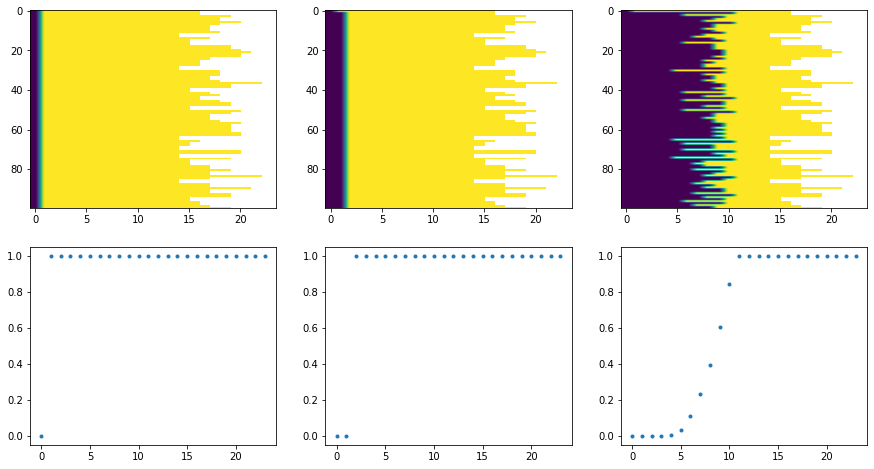

In [6]:
plt.figure(figsize=(15, 8))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(choicelst_all[i][:100,:], aspect='auto')
    
    plt.subplot(2, 3, i + 4)
    plt.plot(np.nanmean(choicelst_all[i], axis=0), '.')

## Simulating behavior in the parameter space

In [10]:
pswitchlst = np.linspace(0.01, 0.45, 20)
prewlst = np.linspace(0.55, 0.99, 20)

gammalst = np.linspace(0.01, 1.4, 20)
epslst = np.linspace(0.01, 0.5, 20)

betalst = 1 / np.linspace(0.05, 2, 20)

agent_type = 'inf-based' #'qlearning' or 'inf-based' or 'v-accumulation'

# Note that this will fit with type 'doublesigmoid'

N_iters = 50
num_states = 2
obs_dim = 1
nblocks = 20  # IMPORTANT: CHECK THIS #for 9.23 run #100
eps = 0
hmm_fit = False
Tmax = 6
sigmoid_window = 30
ntrials_per_block = [15, 25]
version = '122821'

# ntrials_per_block = [10, 40]
seed = 0
np.random.seed(seed)


params = {'N_iters': N_iters, 'num_states': num_states, 'obs_dim': obs_dim, 
          'nblocks': nblocks, 'eps': eps, 'ntrials_per_block': ntrials_per_block,
          'gammalst': gammalst, 'epslst': epslst, 'seed': seed, 'type': agent_type, 'hmm_fit': hmm_fit,
         'pswitchlst': pswitchlst, 'prewlst': prewlst, 
          'betalst': betalst, 'seed': seed, 'sigmoid_window': sigmoid_window, 'Tmax': Tmax}

rootdir = f"{paths['simdatapath']}/{version}"
if not os.path.exists(rootdir):
    os.mkdir(rootdir)
    

for i in range(5):
    rlow = 0.1 * i
    rhigh = 1 - 0.1 * i
    print('Simulating rlow = %.2f, rhigh = %.2f' % (rlow, rhigh))
    params['rlow'] = rlow
    params['rhigh'] = rhigh

    efflist, T11lst, T22lst, E1lst, E2lst, PRslopelist, PLslopelist, \
               PRoffsetlist, PLoffsetlist, LapseL, LapseR, ParamsA, ParamsB, ParamsC, \
               coefs_all, perf_train_all, perf_test_all = run_multiple_agents(params)

    # Save results for inference-based
    filename = f"{rootdir}/EGreedy{agent_type}Agent-withCorr-doublesigmoid-prob{rlow:.2f}to{rhigh:.2f}-{version}.mat"
    results_dict = dict(T11lst=T11lst, T22lst=T22lst, E1lst=E1lst, E2lst=E2lst, efflist=efflist,
                       PRslopelist=PRslopelist, PRoffsetlist=PRoffsetlist, PLoffsetlist=PLoffsetlist,
                       PLslopelist=PLslopelist, LapseL=LapseL, LapseR=LapseR, ParamsA=ParamsA, ParamsB=ParamsB,
                       ParamsC=ParamsC, coefs_all=coefs_all, perf_train_all=perf_train_all, perf_test_all=perf_test_all)
#     results_dict = {'T11lst': T11lst, 'T22lst': T22lst,
#                         'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
#                         'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
#                         'LapseL': LapseL, 'LapseR': LapseR, 'ParamsA': ParamsA, 'ParamsB': ParamsB, 'ParamsC': ParamsC}
    savedict = results_dict.update(params)
    if not os.path.exists(filename):
        scipy.io.savemat(filename, results_dict)
    else:
        print('File exists! Skipping save...')

Simulating rlow = 0.00, rhigh = 1.00
* idx =  0
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     id

     idy =  17
     idy =  18
     idy =  19
* idx =  7
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  8
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  9
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  10
     idy =  0
     idy =  1
     idy =  

     idy =  19
* idx =  14
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  15
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  16
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  17
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy = 

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  4
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  5
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  6
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  17
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  18
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  19
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =

In [201]:
pswitchlst = np.linspace(0.01, 0.45, 20)
prewlst = np.linspace(0.55, 0.99, 20)

gammalst = np.linspace(0.01, 1.4, 20)
epslst = np.linspace(0.01, 0.5, 20)

betalst = 1 / np.linspace(0.05, 2, 20)

agent_type = 'qlearning' #'qlearning' or 'inf-based' or 'v-accumulation'

N_iters = 50
num_states = 2
obs_dim = 1
nblocks = 20 #for 9.23 run #100
eps = 0
hmm_fit = False
sigmoid_window = 30
ntrials_per_block = [15, 25]
version = '122821'
# ntrials_per_block = [10, 40]
seed = 0
np.random.seed(seed)


params = {'N_iters': N_iters, 'num_states': num_states, 'obs_dim': obs_dim, 
          'nblocks': nblocks, 'eps': eps, 'ntrials_per_block': ntrials_per_block,
          'gammalst': gammalst, 'epslst': epslst, 'seed': seed, 'type': agent_type, 'hmm_fit': hmm_fit,
         'pswitchlst': pswitchlst, 'prewlst': prewlst, 
          'betalst': betalst, 'seed': seed, 'sigmoid_window': sigmoid_window, 'Tmax': Tmax}

for i in range(5): #range(1,5):
    rlow = 0.1 * i
    rhigh = 1 - 0.1 * i
    print('Simulating rlow = %.2f, rhigh = %.2f' % (rlow, rhigh))
    params['rlow'] = rlow
    params['rhigh'] = rhigh

    efflist, T11lst, T22lst, E1lst, E2lst, PRslopelist, PLslopelist, \
               PRoffsetlist, PLoffsetlist, LapseL, LapseR, ParamsA, ParamsB, ParamsC, \
               coefs_all, perf_train_all, perf_test_all = run_multiple_agents(params)

    # Save results for inference-based
    filename = f"{rootdir}/EGreedy{agent_type}Agent-withCorr-doublesigmoid-prob{rlow:.2f}to{rhigh:.2f}-{version}.mat"
    results_dict = {'T11lst': T11lst, 'T22lst': T22lst,
                        'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                        'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                        'LapseL': LapseL, 'LapseR': LapseR, 'ParamsA': ParamsA, 'ParamsB': ParamsB, 'ParamsC': ParamsC}
    savedict = results_dict.update(params)
    if not os.path.exists(filename):
        scipy.io.savemat(filename, results_dict)
    else:
        print('File exists! Skipping save...')

Simulating rlow = 0.00, rhigh = 1.00
* idx =  0
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     id

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  4
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  5
     idy =  0
     idy =  1
     idy =  2
     idy =  3


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  18
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  19
     idy =  0


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
Simulating rlow = 0.20, rhigh = 0.80
* idx =  0
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
 

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  4
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  5
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  6
     idy =  0
     idy =  1
     idy =  2

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  16
     idy =  0
     idy =  1


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  17
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  18
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  19
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
Simulating rlow = 0.30, rhigh = 0.70
* idx =  0
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     id

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  9
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  10
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  11
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy = 

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  15
     idy =  0
     idy =  1


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  16
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  17
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  18
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  18
     idy =  19
* idx =  1
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  19
* idx =  2
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  3
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  4
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  5
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  6
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  7
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  8
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  9
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  10
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     i

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  12
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  13
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  14
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     i

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  19
* idx =  16
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  17
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  18
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/src/utils.py:333: RuntimeWarning: overflow encountered in exp
  return gamma + (1 - gamma - lamb) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19
* idx =  19
     idy =  0
     idy =  1
     idy =  2
     idy =  3
     idy =  4
     idy =  5
     idy =  6
     idy =  7
     idy =  8
     idy =  9
     idy =  10
     idy =  11
     idy =  12
     idy =  13
     idy =  14
     idy =  15
     idy =  16
     idy =  17
     idy =  18
     idy =  19


In [252]:
seed = 0
np.random.seed(10)
agent, world, pR, pL, hmm = run_single_agent(0, 1, params)

In [253]:
print(pL, pR)

[0.1939077337167267, -9.667477289465378, 0.047375367945757946] [0.19353304485513467, -10.566567932061293, 0.049678263297248004]


In [254]:
pR, pL, _ = find_LR_transition_fit(world, agent, window=30, type='doublesigmoid')
print(pR, pL)

[0.19353304485513467, -10.566567932061293, 0.049678263297248004] [0.1939077337167267, -9.667477289465378, 0.047375367945757946]


In [255]:
choicelst = split_by_trials(np.array(agent.choice_history), world.ntrialblocks[:-1], chop='max')

In [256]:
if world.rate_history[0][0] > 0.5:
    # print('left')
    leftAverage = np.nanmean(choicelst[1::2, :], axis=0)
    rightAverage = np.nanmean(choicelst[::2, :], axis=0)
else:
    # print('right')
    rightAverage = np.nanmean(choicelst[1::2, :], axis=0)
    leftAverage = np.nanmean(choicelst[::2, :], axis=0)

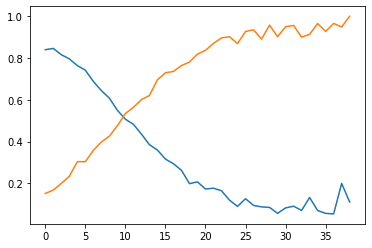

In [257]:
plt.plot(rightAverage)
plt.plot(leftAverage)

In [258]:
pfit = fit_doublesigmoid_helper(leftAverage, rightAverage)

In [259]:
pfit

array([-10.04345214,   0.20164106, -10.15509345,   0.20693645,
         0.04874748,   0.07733714])

In [86]:
pcand = [-0.04, -0.5, -0.04, -0.5, 0.2, 0.2]

In [260]:
[offsetL, slopeL, offsetR, slopeR, lapseL, lapseR] = pfit

In [148]:
pR1 = [slopeR, offsetR, lapseL, lapseR]
pR2 = [1, -5, 0.2, 0.2]
predR = predict_doublesigmoid(offsetsR, pR1)
predL = predict_doublesigmoid(offsetsL, [slopeL, offsetL, lapseR, lapseL])
print(pR1)

[0.9908399470250046, -2.2142081842874597, 0.22535189372367664, 0.2300520718406339]


In [149]:
errordoublesigmoid(pfit, offsetsR, 1-rightAverage, offsetsL, leftAverage)

0.08139879987067777

In [150]:
errordoublesigmoid([-3, 1, -3, 1, 0.2, 0.2], offsetsR, 1-rightAverage, offsetsL, leftAverage)

0.19102933257097912

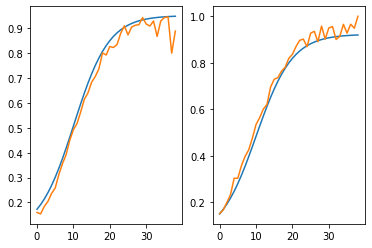

In [261]:
predR = predict_doublesigmoid(offsetsR, [slopeR, offsetR, lapseR, lapseL])
predL = predict_doublesigmoid(offsetsR, [slopeL, offsetL, lapseL, lapseR])


plt.subplot(121)
plt.plot(offsetsR, predR)
plt.plot(offsetsR, 1-rightAverage)

plt.subplot(122)
plt.plot(offsetsL, predL)
plt.plot(offsetsL, leftAverage)

In [55]:
offsetsR = np.arange(len(rightAverage))
offsetsL = np.arange(len(leftAverage))

In [56]:
offsetsR

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

Text(0, 0.5, 'gamma')

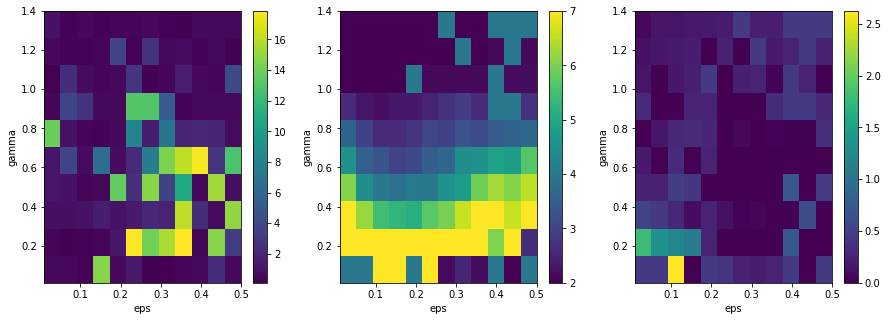

In [22]:
slopeCorr = ParamsB * ParamsA * np.exp(-ParamsA * 3)


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(ParamsA, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(epslst), max(epslst), min(gammalst), max(gammalst)])
plt.colorbar()
plt.xlabel('eps')
plt.ylabel('gamma')

plt.subplot(132)
plt.imshow(ParamsB, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(epslst), max(epslst), min(gammalst), max(gammalst)], vmin=2, vmax=7)
plt.colorbar()
plt.xlabel('eps')
plt.ylabel('gamma')

plt.subplot(133)
plt.imshow(slopeCorr, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(epslst), max(epslst), min(gammalst), max(gammalst)])
plt.colorbar()
plt.xlabel('eps')
plt.ylabel('gamma')

Text(0.5, 1.0, 'Foraging efficiency')

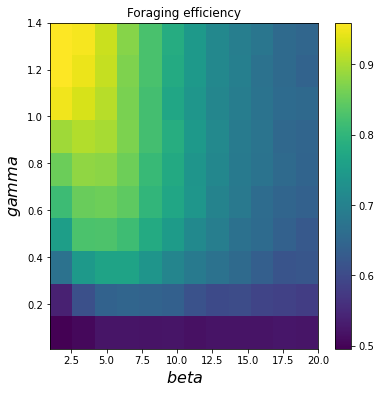

In [29]:
# Figure out some params for plotting depending on the simtype
simtype = params['type'] 
if simtype == 'qlearning':
    xlst = epslst
    ylst = gammalst
    xlabel = 'epsilon'
    ylabel = 'gamma'
    
    
elif simtype == 'inf-based':
    xlst = prewlst
    ylst = pswitchlst
    xlabel = r'$P_{reward}$'
    ylabel = r'$P_{switch}$'
    
elif simtype == 'v-accumulation': 
    xlst = betalst
    ylst = gammalst
    xlabel = r'$beta$'
    ylabel = r'$gamma$'

# Plot of foraging efficiency
plt.figure(figsize=(6, 6))
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Foraging efficiency')


Text(0.5, 1.0, 'Left lapse')

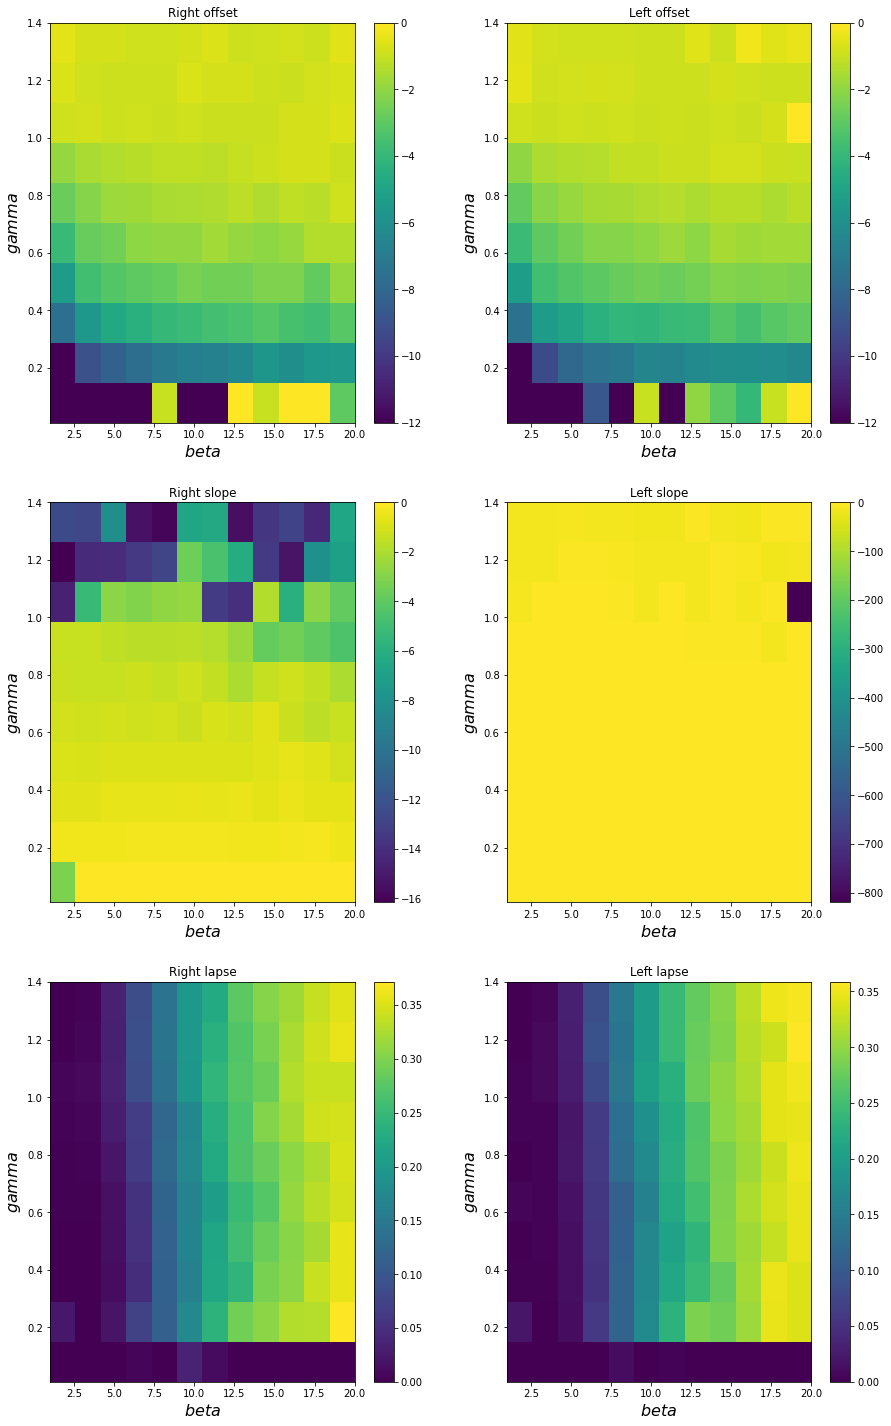

In [30]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 25))
plt.subplot(321)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=-12, vmax=0)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(322)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=-12, vmax=0
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left offset')

plt.subplot(323)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          
        )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right slope')


plt.subplot(324)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left slope')

plt.subplot(325)
plt.imshow(LapseR, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          )
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right lapse')


# Plot of transition probability
plt.subplot(326)
plt.imshow(LapseL, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left lapse')


## Errors vs previous reward correlation
Here we look at the criterion in Mainen's paper: correlation between switch latency and previous reward

In [11]:
def get_zstates(agent, num_states=2, obs_dim=1, N_iters=50):
    '''
    Fit HMM to the choice sequence of the agent
    Returns: the sequence of the most likely z-states
    '''
    # Fit HMM to choice sequence
    data = np.array(agent.choice_history)[:,None] 

    ## testing the constrained transitions class
    hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
    hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)
    
    if hmm.observations.logit_ps[0] > 0:
        return 1 - hmm.most_likely_states(data)
    else:
        return hmm.most_likely_states(data)



def get_switch_times(world, agent):
    '''
    Returns an array of switching times (in trials),
    based on the HMM model fits
    '''
    z_states = get_zstates(agent)
    splits = split_by_trials(z_states, world.ntrialblocks, chop='min')
    # Identify where the switch happens
    if np.ndim(np.array(world.side_history)) == 1:
        first_side=world.side_history[0]
    else:
        first_side=world.side_history[0][0]
    
    switchlst = []
    for i in range(len(splits)):
        arr = splits[i]
#         print(i, first_side, arr)
        # Skip trials that start on the wrong side
        if arr[0] == (first_side + i) % 2:
            switch = -1
            print('skipping')
        else:
            # Find the first element that is the opposite state
            target = (i + first_side) % 2
            if i % 2 == 0:
                cands = np.where(arr == target)[0]
                if len(cands) == 0:
                    switch = world.ntrialblocks[i]
                else:
                    switch = cands[0]

        switchlst.append(switch)
    
    return np.array(switchlst)


def get_num_errors_leading_block(world, agent):
    '''
    Returns an array of switching times (in trials),
    switch times based on the first time animal switches
    '''
    choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
    
    if np.ndim(np.array(world.side_history)) == 1:
        first_side=world.side_history[0]
    else:
        first_side=world.side_history[0][0]
        
    switchlst = []
    for i in range(len(world.ntrialblocks) - 1):
        blockchoice = choicelst[i]
        target = (first_side + i) % 2
        if blockchoice[0] == target:
            switch = -1
        else:
            switch = np.where(blockchoice == target)[0][0]
    
        switchlst.append(switch)
    
    return np.array(switchlst)

def get_num_rewards_trailing_block(world, agent):
    '''
    Returns an array of consec rewards at the end of the block
    switch times based on the first time animal switches
    '''
    choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
    
    if np.ndim(np.array(world.side_history)) == 1:
        first_side=world.side_history[0]
    else:
        first_side=world.side_history[0][0]
        
    nrewlst = []
    for i in range(len(world.ntrialblocks) - 1):
        blockchoice = choicelst[i]
        blockchoiceflip = np.flip(blockchoice)
        target = (first_side + i) % 2
#         print('array is ', blockchoice)
        if blockchoiceflip[0] != target:
            nrew = -1
#             print('skipping')
        else:
            nrew = np.where(blockchoiceflip != target)[0]
#             print(nrew)
            if len(nrew) == 0:
                nrew = len(blockchoiceflip)
            else:
                nrew = nrew[0]
#             print(target)
#             print(nrew)
    
        nrewlst.append(nrew)
    
    return np.array(nrewlst)
    

In [23]:
world = ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 40], nblockmax=100)
# world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = ValueAccumulationAgent(gamma=0.5, beta=10)
# agent = EGreedyQLearningAgent(gamma=0.3, eps=0.1)
exp = Experiment(agent, world)
exp.run()  

choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
arr = choicelst[0]
get_num_rewards_trailing_block(world, agent)

array([19, 24, 30, 12, 14,  1,  3, 12, 10,  9,  4,  4, 18,  2,  2,  5,  1,
       34,  7,  5,  3,  7,  3, 22,  2,  3,  1, 11,  1, 25,  9, 10,  5, 16,
        2, 36, 11,  9,  6,  3,  3,  3, 11,  9,  6,  1, 39,  8, 11, 10,  4,
       10,  4,  4,  5,  9,  7,  6,  9, 10,  2,  8,  8, 20, 23,  3,  6,  5,
       12, 28,  2,  3,  3,  5, 19,  4,  6, 20,  6,  3,  2,  3, 14, 20,  6,
        3, 18, 16,  8,  2, 16,  9,  7,  2,  9, 16,  2,  2,  2, 10])

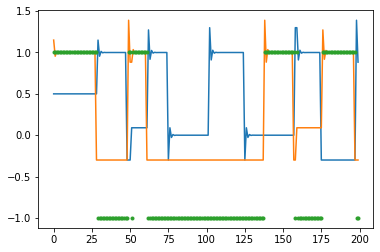

In [18]:
plt.plot(agent.q0_history[:200])
plt.plot(agent.q1_history[:200])

plt.plot(np.array(agent.choice_history[:200]) * 2 - 1, '.')

In [150]:
# np.random.seed(123)
# np.random.seed(127)
rlow = 0
rhigh = 1
nblocks = 100
# ntrials_per_block = [50, 80]
ntrials_per_block = [5, 12]
prew = 0.9
psw = 0.1
eps = 0.1
gamma = 0.8
world = ForagingWorld(prew=0.95, psw=0.1, pstruct=[1, 1000], nblockmax=100)
# world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
exp = Experiment(agent, world)
exp.run()  
choice = agent.choice_history
# Find where the block transitions happen
window = 20
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]
# Get the choices around the transition
choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='max')

z_states = get_zstates(agent)
#splits = split_by_trials(z_states, ntrials, chop=False)
lst = get_switch_times(world, agent)

skipping


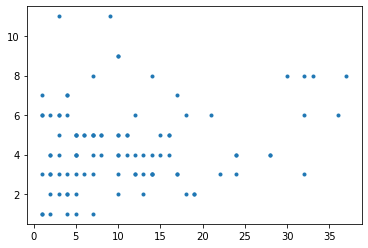

In [22]:
Nerrors = get_num_errors_leading_block(world, agent)
Nrews = get_num_rewards_trailing_block(world, agent)
# plt.plot(lst)
plt.plot(Nrews[:-1], Nerrors[1:], '.')

In [201]:
lst2 = lst.copy().astype('float')
lst2[lst == -1] = np.nan

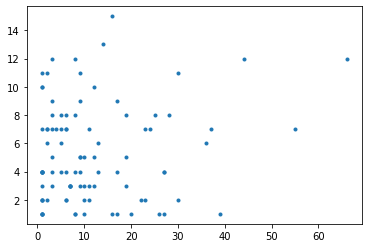

In [193]:
# Is there a correlation?
nafterswitch = world.ntrialblocks[:-1] - lst2
plt.plot(nafterswitch[:-1], lst2[1:], '.')

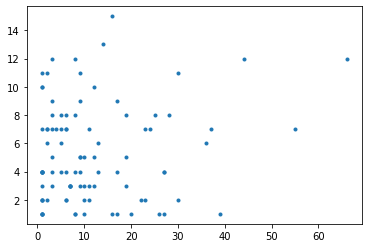

In [202]:
# Is there a correlation?
nafterswitch = world.ntrialblocks[:-1] - lst2
plt.plot(nafterswitch[:-1], lst2[1:], '.')

In [ ]:
plt.imshow(splits[:72,:], aspect='auto')

In [ ]:
# Identify where the switch happens
first_side=world.side_history[0][0]
for i in range(len(splits)):
    arr = splits[i]
    
    # Skip trials that start on the wrong side
    if arr[0] == (first_side + i) % 2:
        switch = -1
        print('skipping')
    else:
        # Find the first element that is the opposite state
        target = (i + first_side) % 2
        if i % 2 == 0:
            cands = np.where(arr == target)[0]
            if len(cands) == 0:
                switch = ntrials[i]
            else:
                switch = cands[0]
        
    print(switch)
        

In [ ]:
# Fit HMM to choice sequence
data = np.array(agent.choice_history)[:,None] 

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

In [ ]:
M,N,P = hmm.expected_states(data)

In [ ]:
len(agent.choice_history)

In [ ]:
plt.plot(M[:300,:])
plt.plot(hmm_z[:300])

In [ ]:
hmm_z = hmm.most_likely_states(data)

#Let's get the emission probs
T = hmm.transitions.transition_matrix

In [ ]:
M = hmm.observations.log_likelihoods(data, None, None, None)
plt.plot(M[:100,:])

In [ ]:
plt.plot(hmm_z[:600])
plt.plot(side_history[:600])

In [ ]:
choicearr = np.array(choicelst)
choicearr.shape

In [ ]:
plt.plot(choicearr[:,8])

In [212]:
# For debugging...
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [30, 40]
prew = 0.9
psw = 0.2
eps = 0
# world = ForagingWorld(prew=0.9, psw=0.05, pstruct=[10, 50], nblockmax=100)
world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=0.6, eps=0.3)
exp = Experiment(agent, world)
exp.run()  

([0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [285]:
N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [50, 80]

world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyInferenceBasedAgent(prew=0.9, pswitch=0.1, eps=0)
exp = Experiment(agent, world)
exp.run()  

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,


In [286]:
find_LR_transition_fit(world, agent, 15)

(array([-5.79242667, -0.49967129,  0.12001928]),
 array([ 8.05137306, -0.30634037,  0.09692759]))

In [275]:
choicelst = split_by_trials(np.array(agent.choice_history), world.ntrialblocks[:-1], chop='min')
fit_sigmoidal(choicelst, False)

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:38: RuntimeWarning: overflow encountered in exp
  preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


(array([-15.93327829,  -0.7210285 ,   0.11101987]),
 array([14.71399924, -0.87172601,  0.1200118 ]))

In [270]:
leftAverage = np.nanmean(choicelst[1::2, :], axis=0)
rightAverage = np.nanmean(choicelst[::2, :], axis=0)

In [284]:
world.rate_history[0][0]

0.9

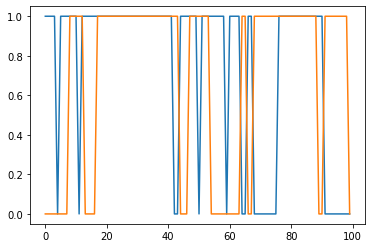

In [279]:
plt.plot(world.side_history[:100])

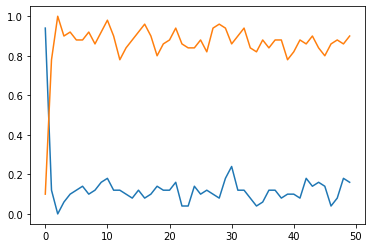

In [274]:
plt.plot(rightAverage)
plt.plot(leftAverage)

In [272]:
world.side_history[0][0]

True

In [259]:
world.side_history[0][0]

True